# Plan of Action
1. Source & Preprocessing of Share Price Data
3.  Application of Long Short Term Memory to Predict Share Price

# 1. Sourcing Share Price Data

In [338]:
#Install the relevant packages that are not already installed

!pip install yfinance

In [0]:
#Import the relevant packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from statsmodels.tools.eval_measures import rmse
from matplotlib.pyplot import figure
import datetime

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,91.639999,93.650002,91.639999,93.339996,91.084122,8152700
2019-01-03,93.209999,94.709999,92.699997,92.860001,90.615730,8277300
2019-01-04,93.209999,93.660004,92.690002,93.440002,91.181717,8029100
2019-01-07,93.620003,95.169998,93.180000,94.540001,92.255127,7789700
2019-01-08,95.059998,95.760002,93.910004,95.199997,92.899178,7200900
2019-01-09,95.709999,96.139999,94.769997,94.889999,92.596672,6272300
2019-01-10,93.879997,94.980003,93.120003,94.959999,92.664978,9396300
2019-01-11,94.989998,95.290001,94.550003,94.839996,92.547874,5394600
2019-01-14,94.480003,95.449997,94.279999,94.949997,92.655212,7085100


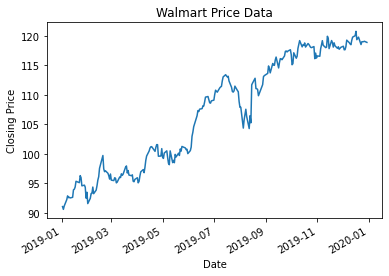

In [340]:
#Define the ticker symbol of Walmart
ticker = 'WMT'

#Define relevant time period
start = '2019-1-1'
end = '2019-12-31'

#Procure the data for this ticker (as a dataframe)
data = yf.download(ticker, start=start, end=end)

#Plot the historical data
data['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Walmart Price Data")

#Inspect the dataframe of the data
data.head(20)

# 2. Data Preprocessing (including splitting into training and test, and normalization)

In [0]:
#Drop the features that are not relevant
data= data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# 3.  Application of Long Short Term Memory to Predict Share Price

## 3.1. Predictions over Period of 5 Trading Days 


In [342]:
#Use the number of trading days over which we are predicting over to be the n_input to the model
T = 5

#Split data into training data and test data 
train_data, test_data = data[:- T], data[- T:]

#Instantiate the data scaler
scaler = MinMaxScaler()

#Fit the scaler to the training data and scale the training data
scaler.fit(train_data)
train_data = scaler.transform(train_data)

#Scale the test data
test_data = scaler.transform(test_data)


#Use the nubmer of trading days over which we are predicting over to be the n_input to the model
n_input = T

#Using a univariate time series (i.e. only looking at adjusted share price)
n_features = 1

#Instatiate the series generator
generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=200)

#Instatiate the model
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=50)

#Create an empty list for the predicted prices
predictions_list = []

#Set up the batch to be used in the algorithm
batch = train_data[-n_input:].reshape((1, n_input, n_features))

#Loop through using the model for each day we are predicting and append the prediction (also adding the new predicted value to the batch)
for i in range(n_input):
  predictions_list.append(model.predict(batch)[0])
  batch = np.append(batch[:, 1:, :], [[predictions_list[i]]], axis=1)

#Rescale the predictions
predictions_dataframe_five = pd.DataFrame(scaler.inverse_transform(predictions_list), index=data[-n_input:].index, columns=['5-day Predicted Adj Close'])

Epoch 1/50
2/2 [==============================] - 0s 221ms/step - loss: 0.4477
Epoch 2/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4058
Epoch 3/50
2/2 [==============================] - 0s 35ms/step - loss: 0.3571
Epoch 4/50
2/2 [==============================] - 0s 33ms/step - loss: 0.3173
Epoch 5/50
2/2 [==============================] - 0s 31ms/step - loss: 0.2637
Epoch 6/50
2/2 [==============================] - 0s 33ms/step - loss: 0.2265
Epoch 7/50
2/2 [==============================] - 0s 33ms/step - loss: 0.1693
Epoch 8/50
2/2 [==============================] - 0s 33ms/step - loss: 0.1283
Epoch 9/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0740
Epoch 10/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0351
Epoch 11/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0182
Epoch 12/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0147
Epoch 13/50
2/2 [==============================] - 0s 33ms/s

## 3.2. Predictions over Period of 10 Trading Days 

In [343]:
#Use the number of trading days over which we are predicting over to be the n_input to the model
T = 10

#Split data into training data and test data 
train_data, test_data = data[:- T], data[- T:]

#Instantiate the data scaler
scaler = MinMaxScaler()

#Fit the scaler to the training data and scale the training data
scaler.fit(train_data)
train_data = scaler.transform(train_data)

#Scale the test data
test_data = scaler.transform(test_data)


#Use the nubmer of trading days over which we are predicting over to be the n_input to the model
n_input = T

#Using a univariate time series (i.e. only looking at adjusted share price)
n_features = 1

#Instatiate the series generator
generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=200)

#Instatiate the model
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=50)

#Create an empty list for the predicted prices
predictions_list = []

#Set up the batch to be used in the algorithm
batch = train_data[-n_input:].reshape((1, n_input, n_features))

#Loop through using the model for each day we are predicting and append the prediction (also adding the new predicted value to the batch)
for i in range(n_input):
  predictions_list.append(model.predict(batch)[0])
  batch = np.append(batch[:, 1:, :], [[predictions_list[i]]], axis=1)

#Rescale the predictions
predictions_dataframe_ten = pd.DataFrame(scaler.inverse_transform(predictions_list), index=data[-n_input:].index, columns=['10-day Predicted Adj Close'])

Epoch 1/50
2/2 [==============================] - 1s 265ms/step - loss: 0.6213
Epoch 2/50
2/2 [==============================] - 0s 55ms/step - loss: 0.5191
Epoch 3/50
2/2 [==============================] - 0s 60ms/step - loss: 0.4358
Epoch 4/50
2/2 [==============================] - 0s 58ms/step - loss: 0.3565
Epoch 5/50
2/2 [==============================] - 0s 55ms/step - loss: 0.2795
Epoch 6/50
2/2 [==============================] - 0s 57ms/step - loss: 0.2068
Epoch 7/50
2/2 [==============================] - 0s 57ms/step - loss: 0.1318
Epoch 8/50
2/2 [==============================] - 0s 57ms/step - loss: 0.0590
Epoch 9/50
2/2 [==============================] - 0s 58ms/step - loss: 0.0219
Epoch 10/50
2/2 [==============================] - 0s 59ms/step - loss: 0.0320
Epoch 11/50
2/2 [==============================] - 0s 55ms/step - loss: 0.0804
Epoch 12/50
2/2 [==============================] - 0s 55ms/step - loss: 0.0380
Epoch 13/50
2/2 [==============================] - 0s 56ms/s

## 3.3. Predictions over Period of 20 Trading Days 

In [344]:
#Use the number of trading days over which we are predicting over to be the n_input to the model
T = 20

#Split data into training data and test data 
train_data, test_data = data[:- T], data[- T:]

#Instantiate the data scaler
scaler = MinMaxScaler()

#Fit the scaler to the training data and scale the training data
scaler.fit(train_data)
train_data = scaler.transform(train_data)

#Scale the test data
test_data = scaler.transform(test_data)


#Use the nubmer of trading days over which we are predicting over to be the n_input to the model
n_input = T

#Using a univariate time series (i.e. only looking at adjusted share price)
n_features = 1

#Instatiate the series generator
generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=200)

#Instatiate the model
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=50)

#Create an empty list for the predicted prices
predictions_list = []

#Set up the batch to be used in the algorithm
batch = train_data[-n_input:].reshape((1, n_input, n_features))

#Loop through using the model for each day we are predicting and append the prediction (also adding the new predicted value to the batch)
for i in range(n_input):
  predictions_list.append(model.predict(batch)[0])
  batch = np.append(batch[:, 1:, :], [[predictions_list[i]]], axis=1)

#Rescale the predictions
predictions_dataframe_twenty = pd.DataFrame(scaler.inverse_transform(predictions_list), index=data[-n_input:].index, columns=['20-day Predicted Adj Close'])

Epoch 1/50
2/2 [==============================] - 1s 264ms/step - loss: 0.5225
Epoch 2/50
2/2 [==============================] - 0s 100ms/step - loss: 0.4348
Epoch 3/50
2/2 [==============================] - 0s 101ms/step - loss: 0.3586
Epoch 4/50
2/2 [==============================] - 0s 98ms/step - loss: 0.2627
Epoch 5/50
2/2 [==============================] - 0s 102ms/step - loss: 0.1755
Epoch 6/50
2/2 [==============================] - 0s 95ms/step - loss: 0.0729
Epoch 7/50
2/2 [==============================] - 0s 95ms/step - loss: 0.0188
Epoch 8/50
2/2 [==============================] - 0s 97ms/step - loss: 0.0320
Epoch 9/50
2/2 [==============================] - 0s 98ms/step - loss: 0.0235
Epoch 10/50
2/2 [==============================] - 0s 97ms/step - loss: 0.0075
Epoch 11/50
2/2 [==============================] - 0s 95ms/step - loss: 0.0196
Epoch 12/50
2/2 [==============================] - 0s 98ms/step - loss: 0.0206
Epoch 13/50
2/2 [==============================] - 0s 96m

## 3.4. Predictions over Period of 60 Trading Days 

In [345]:
#Use the number of trading days over which we are predicting over to be the n_input to the model
T = 60

#Split data into training data and test data 
train_data, test_data = data[:- T], data[- T:]

#Instantiate the data scaler
scaler = MinMaxScaler()

#Fit the scaler to the training data and scale the training data
scaler.fit(train_data)
train_data = scaler.transform(train_data)

#Scale the test data
test_data = scaler.transform(test_data)


#Use the nubmer of trading days over which we are predicting over to be the n_input to the model
n_input = T

#Using a univariate time series (i.e. only looking at adjusted share price)
n_features = 1

#Instatiate the series generator
generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=200)

#Instatiate the model
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=50)

#Create an empty list for the predicted prices
predictions_list = []

#Set up the batch to be used in the algorithm
batch = train_data[-n_input:].reshape((1, n_input, n_features))

#Loop through using the model for each day we are predicting and append the prediction (also adding the new predicted value to the batch)
for i in range(n_input):
  predictions_list.append(model.predict(batch)[0])
  batch = np.append(batch[:, 1:, :], [[predictions_list[i]]], axis=1)

#Rescale the predictions
predictions_dataframe_sixty = pd.DataFrame(scaler.inverse_transform(predictions_list), index=data[-n_input:].index, columns=['60-day Predicted Adj Close'])

Epoch 1/50
1/1 [==============================] - 1s 655ms/step - loss: 0.4480
Epoch 2/50
1/1 [==============================] - 0s 345ms/step - loss: 0.4005
Epoch 3/50
1/1 [==============================] - 0s 344ms/step - loss: 0.3600
Epoch 4/50
1/1 [==============================] - 0s 364ms/step - loss: 0.3176
Epoch 5/50
1/1 [==============================] - 0s 363ms/step - loss: 0.2856
Epoch 6/50
1/1 [==============================] - 0s 354ms/step - loss: 0.2499
Epoch 7/50
1/1 [==============================] - 0s 347ms/step - loss: 0.2157
Epoch 8/50
1/1 [==============================] - 0s 353ms/step - loss: 0.1770
Epoch 9/50
1/1 [==============================] - 0s 355ms/step - loss: 0.1360
Epoch 10/50
1/1 [==============================] - 0s 347ms/step - loss: 0.1003
Epoch 11/50
1/1 [==============================] - 0s 350ms/step - loss: 0.0605
Epoch 12/50
1/1 [==============================] - 0s 361ms/step - loss: 0.0211
Epoch 13/50
1/1 [==============================] 

## 3.4 Comparison of Different Prediction Time Periods

In [0]:
list_of_dataframes_to_concat = [data, predictions_dataframe_five, predictions_dataframe_ten, predictions_dataframe_twenty, predictions_dataframe_sixty]
data_with_predictions = pd.concat(list_of_dataframes_to_concat, axis=1)

In [347]:
data_with_predictions.tail(10)

,Adj Close,5-day Predicted Adj Close,10-day Predicted Adj Close,20-day Predicted Adj Close,60-day Predicted Adj Close
Date,,,,,
2019-12-16,120.008987,NaN,119.143623,116.853741,142.211495
2019-12-17,120.745728,NaN,119.240345,116.780965,143.673237
2019-12-18,119.331985,NaN,119.423221,116.690503,145.260256
2019-12-19,119.551018,NaN,119.622666,116.604031,146.989724
2019-12-20,119.760094,NaN,119.773963,116.526355,148.882565
2019-12-23,118.505638,119.763765,119.825066,116.439450,150.963568
2019-12-24,118.983528,119.718543,119.933417,116.358997,153.262372
2019-12-26,118.993477,119.460560,120.087811,116.282786,155.815426
2019-12-27,119.063171,119.514677,120.260609,116.203117,158.668444


In [0]:
#Calculate the % error in each of the prediction
data_with_predictions['% Error in 5-day Predicted Adj Close'] = 100*(data_with_predictions['5-day Predicted Adj Close'].divide(data_with_predictions['Adj Close'])-1)
data_with_predictions['% Error in 10-day Predicted Adj Close'] = 100*(data_with_predictions['10-day Predicted Adj Close'].divide(data_with_predictions['Adj Close'])-1)
data_with_predictions['% Error in 20-day Predicted Adj Close'] = 100*(data_with_predictions['20-day Predicted Adj Close'].divide(data_with_predictions['Adj Close'])-1)
data_with_predictions['% Error in 60-day Predicted Adj Close'] = 100*(data_with_predictions['60-day Predicted Adj Close'].divide(data_with_predictions['Adj Close'])-1)

In [349]:
data_with_predictions.tail(5)

,Adj Close,5-day Predicted Adj Close,10-day Predicted Adj Close,20-day Predicted Adj Close,60-day Predicted Adj Close,% Error in 5-day Predicted Adj Close,% Error in 10-day Predicted Adj Close,% Error in 20-day Predicted Adj Close,% Error in 60-day Predicted Adj Close
Date,,,,,,,,,
2019-12-23,118.505638,119.763765,119.825066,116.439450,150.963568,1.061660,1.113388,-1.743535,27.389355
2019-12-24,118.983528,119.718543,119.933417,116.358997,153.262372,0.617745,0.798337,-2.205794,28.809739
2019-12-26,118.993477,119.460560,120.087811,116.282786,155.815426,0.392528,0.919659,-2.278016,30.944510
2019-12-27,119.063171,119.514677,120.260609,116.203117,158.668444,0.379215,1.005716,-2.402132,33.264083
2019-12-30,118.874016,119.513027,120.364546,116.128006,161.878039,0.537553,1.253874,-2.310017,36.176134


Text(0.5, 1.0, 'Walmart Price Data and Predictions')

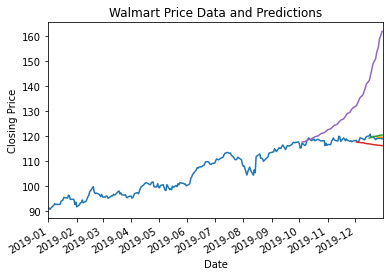

In [350]:
#Plot the historical data and predictions
data_with_predictions['Adj Close'].plot()
data_with_predictions['5-day Predicted Adj Close'].plot()
data_with_predictions['10-day Predicted Adj Close'].plot()
data_with_predictions['20-day Predicted Adj Close'].plot()
data_with_predictions['60-day Predicted Adj Close'].plot()
plt.xlim(datetime.date(2019,1,1), datetime.date(2019,12, 31))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Walmart Price Data and Predictions")

Text(0.5, 1.0, 'Error in Predictions')

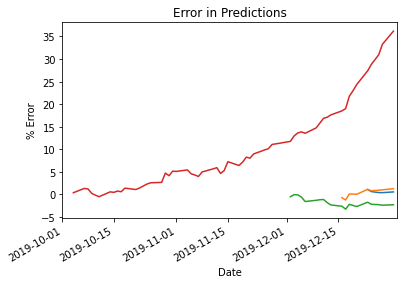

In [353]:
#Plot the error in the predictions
data_with_predictions['% Error in 5-day Predicted Adj Close'].plot()
data_with_predictions['% Error in 10-day Predicted Adj Close'].plot()
data_with_predictions['% Error in 20-day Predicted Adj Close'].plot()
data_with_predictions['% Error in 60-day Predicted Adj Close'].plot()
plt.xlim(datetime.date(2019,10,1), datetime.date(2019,12, 31))
plt.xlabel("Date")
plt.ylabel("% Error")
plt.title("Error in Predictions")

As shown by the graphs, and as expected, when predicting share prices for a date that is a greater number of days in the future, the magnitude of error in the prediction is greater.